In [1]:
import torch
from torch import nn
import torch.functional as f
import torch.utils.data as Data
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
y = df['SalePrice'].values.reshape(-1,1)
x = df.drop(['Id', 'SalePrice'], axis=1)

In [5]:
x['LotFrontage'].fillna(np.mean(x['LotFrontage']), inplace=True)
x['MasVnrArea'].fillna(0, inplace=True)
x['GarageYrBlt'].fillna(0, inplace=True)
x.fillna('NAN', inplace=True)

In [6]:
le = preprocessing.LabelEncoder()
scaler = preprocessing.StandardScaler()

In [7]:
for i in x:
    if type(x[i][0]) is str:
        x[i] = le.fit_transform(x[i])
x = x.values

In [8]:

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
x_train = torch.FloatTensor(x_train).cuda()
y_train = torch.FloatTensor(y_train).cuda()
x_test = torch.FloatTensor(x_test).cuda()
y_test = torch.FloatTensor(y_test).cuda()

In [9]:
dataset = Data.TensorDataset(x_train, y_train)
dataloader = Data.DataLoader(dataset=dataset, batch_size=512, shuffle=True)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(79, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [11]:
model = Net().cuda()

In [12]:
print(model)

Net(
  (model): Sequential(
    (0): Linear(in_features=79, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [13]:
criterion = nn.MSELoss()

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
history = dict()
history['loss']=[]
history['val_loss']=[]

In [16]:
for epoch in range(100):
    for x_batch, y_batch in dataloader:
        model.train()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.eval()
        y_pred = model(x_test)
        val_loss = criterion(y_pred, y_test)
        loss = loss.item()
        val_loss = val_loss.item()
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    print(f'loss:{loss:.5f} - val_loss:{val_loss:.5f}')

loss:2.18949 - val_loss:1.73327
loss:0.70735 - val_loss:6.17740
loss:0.48382 - val_loss:11.65457
loss:0.24627 - val_loss:7.86806
loss:0.36065 - val_loss:11.32617
loss:0.27321 - val_loss:5.62142
loss:0.30307 - val_loss:2.49375
loss:0.18232 - val_loss:3.84322
loss:0.27882 - val_loss:4.72990
loss:0.25217 - val_loss:2.10951
loss:0.42472 - val_loss:1.63999
loss:0.21880 - val_loss:2.35954
loss:0.36427 - val_loss:1.43224
loss:0.19404 - val_loss:1.20712
loss:0.23414 - val_loss:1.00783
loss:0.21226 - val_loss:1.13881
loss:0.17303 - val_loss:1.10987
loss:0.39808 - val_loss:0.66730
loss:0.20684 - val_loss:1.06148
loss:0.18138 - val_loss:0.60964
loss:0.21072 - val_loss:0.37993
loss:0.13887 - val_loss:1.10529
loss:0.12804 - val_loss:0.61925
loss:0.16784 - val_loss:0.67972
loss:0.22966 - val_loss:1.20655
loss:0.09802 - val_loss:0.38880
loss:0.17934 - val_loss:1.09359
loss:0.16782 - val_loss:1.18966
loss:0.13497 - val_loss:0.41233
loss:0.16738 - val_loss:1.01369
loss:0.16438 - val_loss:1.47223
loss:0

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(100):
    for x_batch, y_batch in dataloader:
        model.train()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.eval()
        y_pred = model(x_test)
        val_loss = criterion(y_pred, y_test)
        loss = loss.item()
        val_loss = val_loss.item()
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    print(f'loss:{loss:.5f} - val_loss:{val_loss:.5f}')

loss:0.05748 - val_loss:0.26717
loss:0.06901 - val_loss:0.17660
loss:0.06124 - val_loss:0.13491
loss:0.05687 - val_loss:0.11805
loss:0.04792 - val_loss:0.11124
loss:0.06837 - val_loss:0.10971
loss:0.04886 - val_loss:0.10994
loss:0.04795 - val_loss:0.10944
loss:0.05045 - val_loss:0.11074
loss:0.05825 - val_loss:0.11109
loss:0.06188 - val_loss:0.11330
loss:0.05903 - val_loss:0.11316
loss:0.09592 - val_loss:0.10984
loss:0.04961 - val_loss:0.10965
loss:0.06388 - val_loss:0.10902
loss:0.07632 - val_loss:0.10876
loss:0.06832 - val_loss:0.10855
loss:0.03448 - val_loss:0.10925
loss:0.04370 - val_loss:0.11047
loss:0.06167 - val_loss:0.11047
loss:0.05235 - val_loss:0.11163
loss:0.04630 - val_loss:0.11174
loss:0.07627 - val_loss:0.11195
loss:0.06742 - val_loss:0.11088
loss:0.04566 - val_loss:0.11062
loss:0.08772 - val_loss:0.11047
loss:0.05284 - val_loss:0.11021
loss:0.06272 - val_loss:0.10950
loss:0.05657 - val_loss:0.10897
loss:0.05967 - val_loss:0.10807
loss:0.04212 - val_loss:0.10693
loss:0.0

In [18]:
model.eval()
with torch.no_grad():
    predict = model(x_test).cpu().numpy()

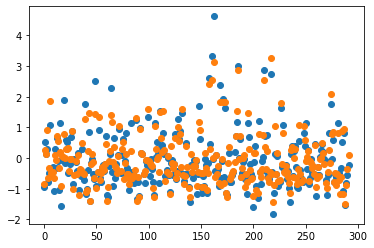

In [19]:
y_test = y_test.cpu().numpy()
plt.scatter(range(y_test.shape[0]), y_test)
plt.scatter(range(predict.shape[0]), predict)

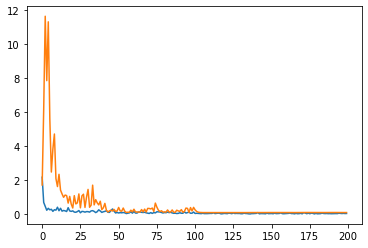

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [21]:
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [22]:
test.drop(['Id'], axis=1, inplace=True)

In [23]:
test['LotFrontage'].fillna(np.mean(test['LotFrontage']), inplace=True)
test['BsmtFinSF1'].fillna(np.mean(test['BsmtFinSF1']), inplace=True)
test['BsmtFinSF2'].fillna(np.mean(test['BsmtFinSF2']), inplace=True)
test['BsmtUnfSF'].fillna(np.mean(test['BsmtUnfSF']), inplace=True)
test['TotalBsmtSF'].fillna(np.mean(test['TotalBsmtSF']), inplace=True)
test['BsmtFullBath'].fillna(np.mean(test['BsmtFullBath']), inplace=True)
test['BsmtHalfBath'].fillna(np.mean(test['BsmtHalfBath']), inplace=True)
test['GarageCars'].fillna(np.mean(test['GarageCars']), inplace=True)
test['GarageArea'].fillna(np.mean(test['GarageCars']), inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)
test.fillna('NAN', inplace=True)

In [24]:
for i in test:
    if type(test[i][0]) is str:
        test[i] = le.fit_transform(test[i])
        
        

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   int64  
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   int64  
 5   Alley          1459 non-null   int64  
 6   LotShape       1459 non-null   int64  
 7   LandContour    1459 non-null   int64  
 8   Utilities      1459 non-null   int64  
 9   LotConfig      1459 non-null   int64  
 10  LandSlope      1459 non-null   int64  
 11  Neighborhood   1459 non-null   int64  
 12  Condition1     1459 non-null   int64  
 13  Condition2     1459 non-null   int64  
 14  BldgType       1459 non-null   int64  
 15  HouseStyle     1459 non-null   int64  
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [26]:
test = torch.FloatTensor(test.values).cuda()

In [27]:
with torch.no_grad():
    ans = model(test).cpu().numpy()

ans = scaler.inverse_transform(ans)

In [28]:
ans.shape

(1459, 1)

In [29]:
result = pd.read_csv('sample_submission.csv')
result = result.drop(columns=['SalePrice'], axis=1)

In [30]:
result['SalePrice'] = ans

In [31]:
result.to_csv('submission.csv', index=False)

In [41]:
result

,Id,SalePrice
0,1461,128984.546875
1,1462,165148.187500
2,1463,193733.328125
3,1464,184746.296875
4,1465,187741.609375
...,...,...
1454,2915,86688.632812
1455,2916,90779.203125
1456,2917,191905.656250
1457,2918,113579.695312
